In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

# GM0 Performance Evaluation

**IMPORTANT**: This notebook should be used as a base for the evaluation of different models. 

- Please **make a copy of this notebook** whenever you want to evaluate a model. Load the desired model by changing the following `model_path_str` variable. 
- This notebook is currently not saving any generated plot. Please make sure to not overwrite the outputs, or to save the plots whenever needed. 
- This notebook saves the generated data. Please refer to the Evaluation section of this notebook. 

Available models on the SDSC shared folder: 

In [3]:
!ls /store/sdsc/sd28/models/GM0/diffusion/

1D-UNET-DDPM-envelope
consistency-model-1D_SignalWithEnvelope-hilbert-log-log_offset:1.0e-05
ddim-1D_SignalWithEnvelope-hilbert-log-log_offset:1.0e-05
ddim-pred:epsilon-1D_SignalWithEnvelope-hilbert-log-log_offset:1.0e-05
ddim-pred:epsilon-1D_SignalWithEnvelope-hilbert-log-log_offset:1.0e-05-normalize-scalar:True
ddim-pred:sample-1D-downsampling:1_LogSpectrogram-{}
ddim-pred:sample-1D-downsampling:1_SignalWithEnvelope-first_order_lp-log-log_offset:1.0e-05-normalize-scalar:True
ddim-pred:sample-1D-downsampling:1_SignalWithEnvelope-hilbert-log-log_offset:1.0e-05-normalize-scalar:True
ddim-pred:sample-1D-downsampling:1_SignalWithEnvelope-moving_average-log-log_offset:1.0e-05-normalize-scalar:True
ddim-pred:sample-1D-downsampling:2_LogSpectrogram-{}
ddim-pred:sample-1D-downsampling:2_SignalWithEnvelope-first_order_lp-log-log_offset:1.0e-05-normalize-scalar:True
ddim-pred:sample-1D-downsampling:2_SignalWithEnvelope-hilbert-log-log_offset:1.0e-05-normalize-scalar:True
ddim-pred:sample-1D-dow

In [4]:
dataset_folder = "../outputs/"

One can either choose a specific checkpoint of a model or the most recent checkpoint of that model (default):

In [5]:
# Pick the last checkpoint of the model
model_path_str = dataset_folder + "ddim-pred:sample-2D-downsampling:1_LogSpectrogram-hop_size:16stft_channels:128"

# Or pick a specific checkpoint
# model_path_str = dataset_folder + "/ddim-pred:sample-1D-downsampling:2_SignalWithEnvelope-moving_average_shifted-log-log_offset:1.0e-05-normalize-scalar:True/name=0_epoch=125-val_loss=0.02.ckpt"

Import the needed libraries, modules and needed variables

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os

from pathlib import Path
from tqdne.utils import *
from tqdne.conf import Config
from tqdne.metric import *

/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(
/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/diffusers/utils/outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [7]:
if torch.cuda.is_available():
    device = torch.device('cuda')
    torch.cuda.empty_cache()
else: 
    device = torch.device('cpu')

torch.cuda.is_available(), device

(True, device(type='cuda'))

In [8]:
config = Config()

# Select the signal length
signal_length = config.signal_length 

# Set the sampling frequency
fs = config.fs

# Set the number of channels of the original waveforms  
n_channels = config.num_channels

# Set the conditioning parameters range
cond_params_range = config.conditional_params_range

Load the model

2024-04-25 23:54:16 - root - INFO - Last checkpoint is : ../outputs/ddim-pred:sample-2D-downsampling:1_LogSpectrogram-hop_size:16stft_channels:128/name=0_epoch=91-val_loss=0.01.ckpt
/users/abosisio/miniforge3/envs/tqdne/lib/python3.11/site-packages/pytorch_lightning/utilities/parsing.py:199: Attribute 'net' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['net'])`.


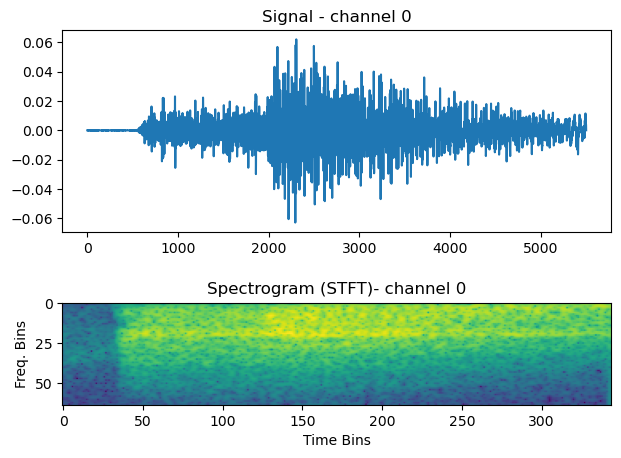

Model: LightningDiffusion
Number of learnable parameters: 38139459
Model size: 458.24 MB
UNet scheme: 
 base num. channels: 32 
 channel multipliers (down/up blocks): (1, 2, 4, 8) 
 num. ResBlocks per down/up block: 2 
 use Attention: True 
 conv. kernel size: 5 
Diffusion prediction type: sample
Learning rate schedule: 
 start: 0.0003 
 scheduler: cosine 
 warmup steps: 500
Batch size: 50
The model was trained on signals with length 5472, as the sampling rate used was 100, whihc is the original sampling rate.
Data representation shape: (1, 3, 64, 344) (batch_size, channels, signal_length)
Data representation name: LogSpectrogram
ckpt file: ../outputs/ddim-pred:sample-2D-downsampling:1_LogSpectrogram-hop_size:16stft_channels:128/name=0_epoch=91-val_loss=0.01.ckpt


In [9]:
model, model_data_repr, ckpt = load_model(Path(model_path_str), use_ddim=False)
model.to(device)
model.eval()
print_model_info(model, model_data_repr, ckpt)

Restore the sampling rate and signal length that were used during training

In [10]:
if "downsampling" in model_path_str:
    downsampling = int(model_path_str.split("downsampling:")[1].split("_")[0])
    fs = fs // downsampling
    signal_length = signal_length // downsampling
    config.signal_length = signal_length
    config.fs = fs
    print(f"Updated signal length: {config.signal_length} and fs: {config.fs}")
else:
    downsampling = 1    

Updated signal length: 5472 and fs: 100


Let's generate a batch of data

In [11]:
# Select the batch size.
batch_size = model.hparams.optimizer_params.batch_size

# One can also choose the batch size
# batch_size = 32

batch_size

50

In [12]:
# Insert values for the conditional input parameters.
# Please read generate_cond_inputs documentation (in utils.py) to understand the structure of cond_input_params dictionary
cond_input_params = {
    "hypocentral_distance": [10, 100, 150],
    "is_shallow_crustal": [0],
    "magnitude": [5.5, 4, 7, 8.5],
    "vs30": None,
}

data_raw = generate_data(model, model_data_representation=model_data_repr, raw_output=True, num_samples=batch_size, cond_input_params=cond_input_params, device=device.type, max_batch_size=batch_size)
data_raw['waveforms'].shape, data_raw['cond'].shape

Batch 1/1


100%|██████████| 100/100 [00:44<00:00,  2.26it/s]


((50, 3, 64, 344), (50, 4))

In [13]:
data_raw_wf = data_raw['waveforms']
data_raw_wf.shape

(50, 3, 64, 344)

In [14]:
data_wf = model_data_repr.invert_representation(data_raw_wf)
data_wf.shape

(50, 3, 5472)

## Single Sample Visualization

Let's investigate model's raw output 

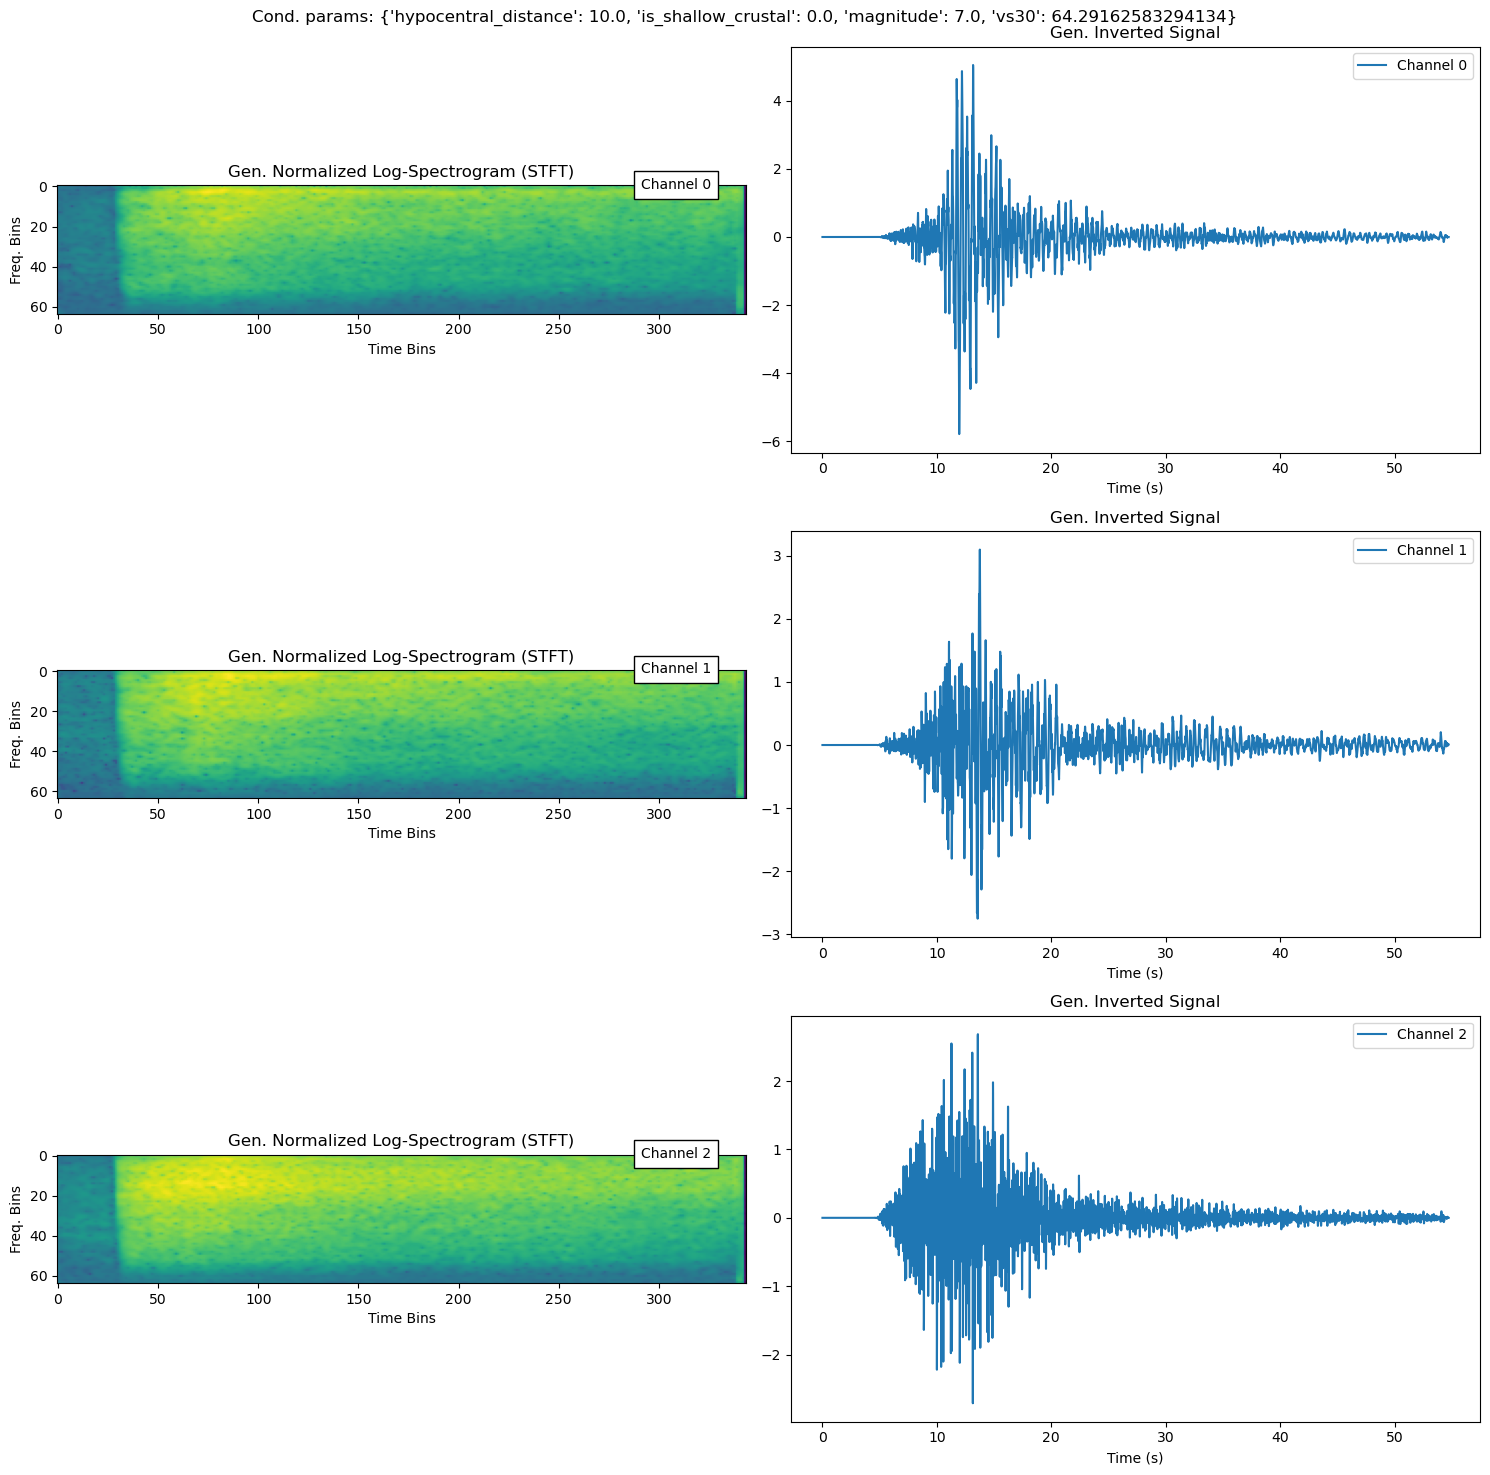

In [15]:
sample_index = 0
plot_raw_waveform(data_raw_wf[sample_index], data_raw['cond'][sample_index], model_data_repr, data_wf[sample_index])

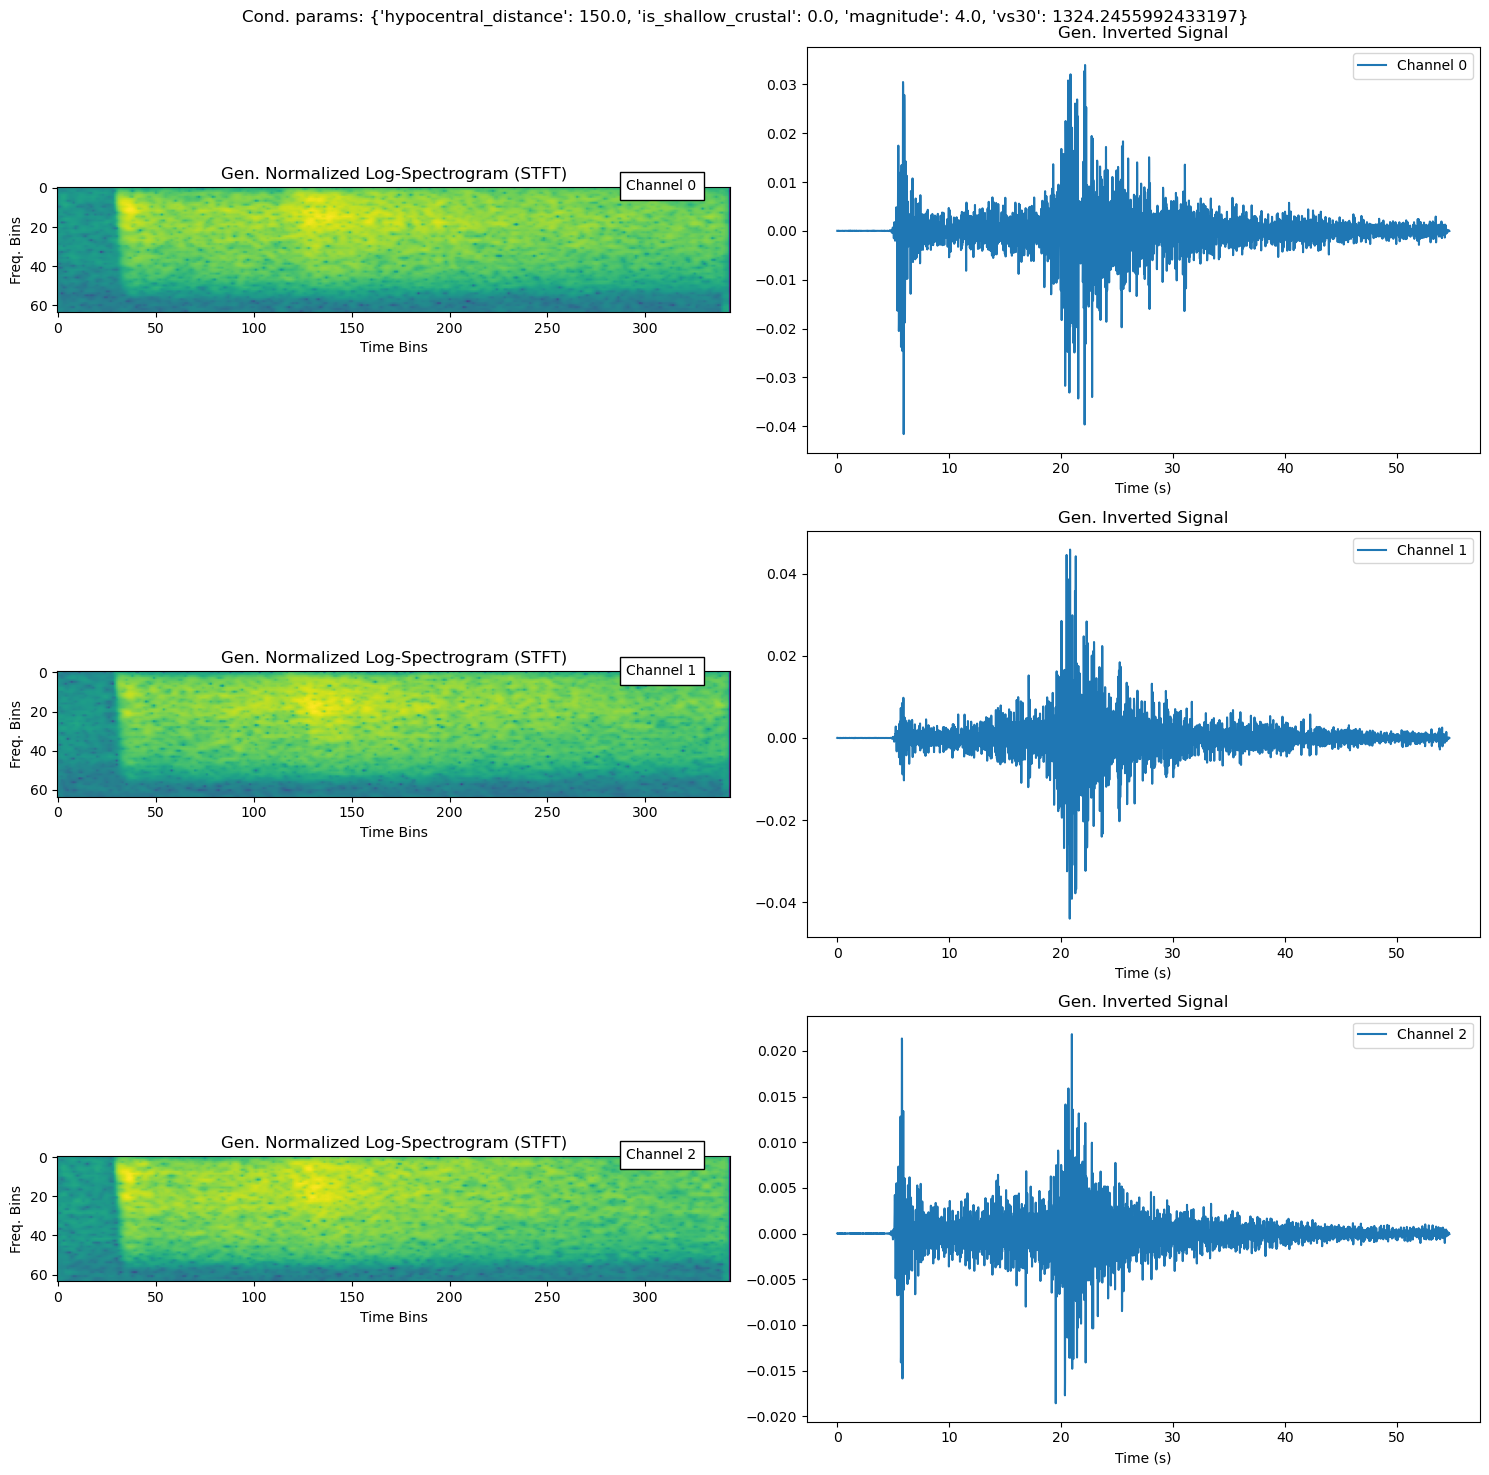

In [16]:
sample_index = 3
plot_raw_waveform(data_raw_wf[sample_index], data_raw['cond'][sample_index], model_data_repr, data_wf[sample_index])

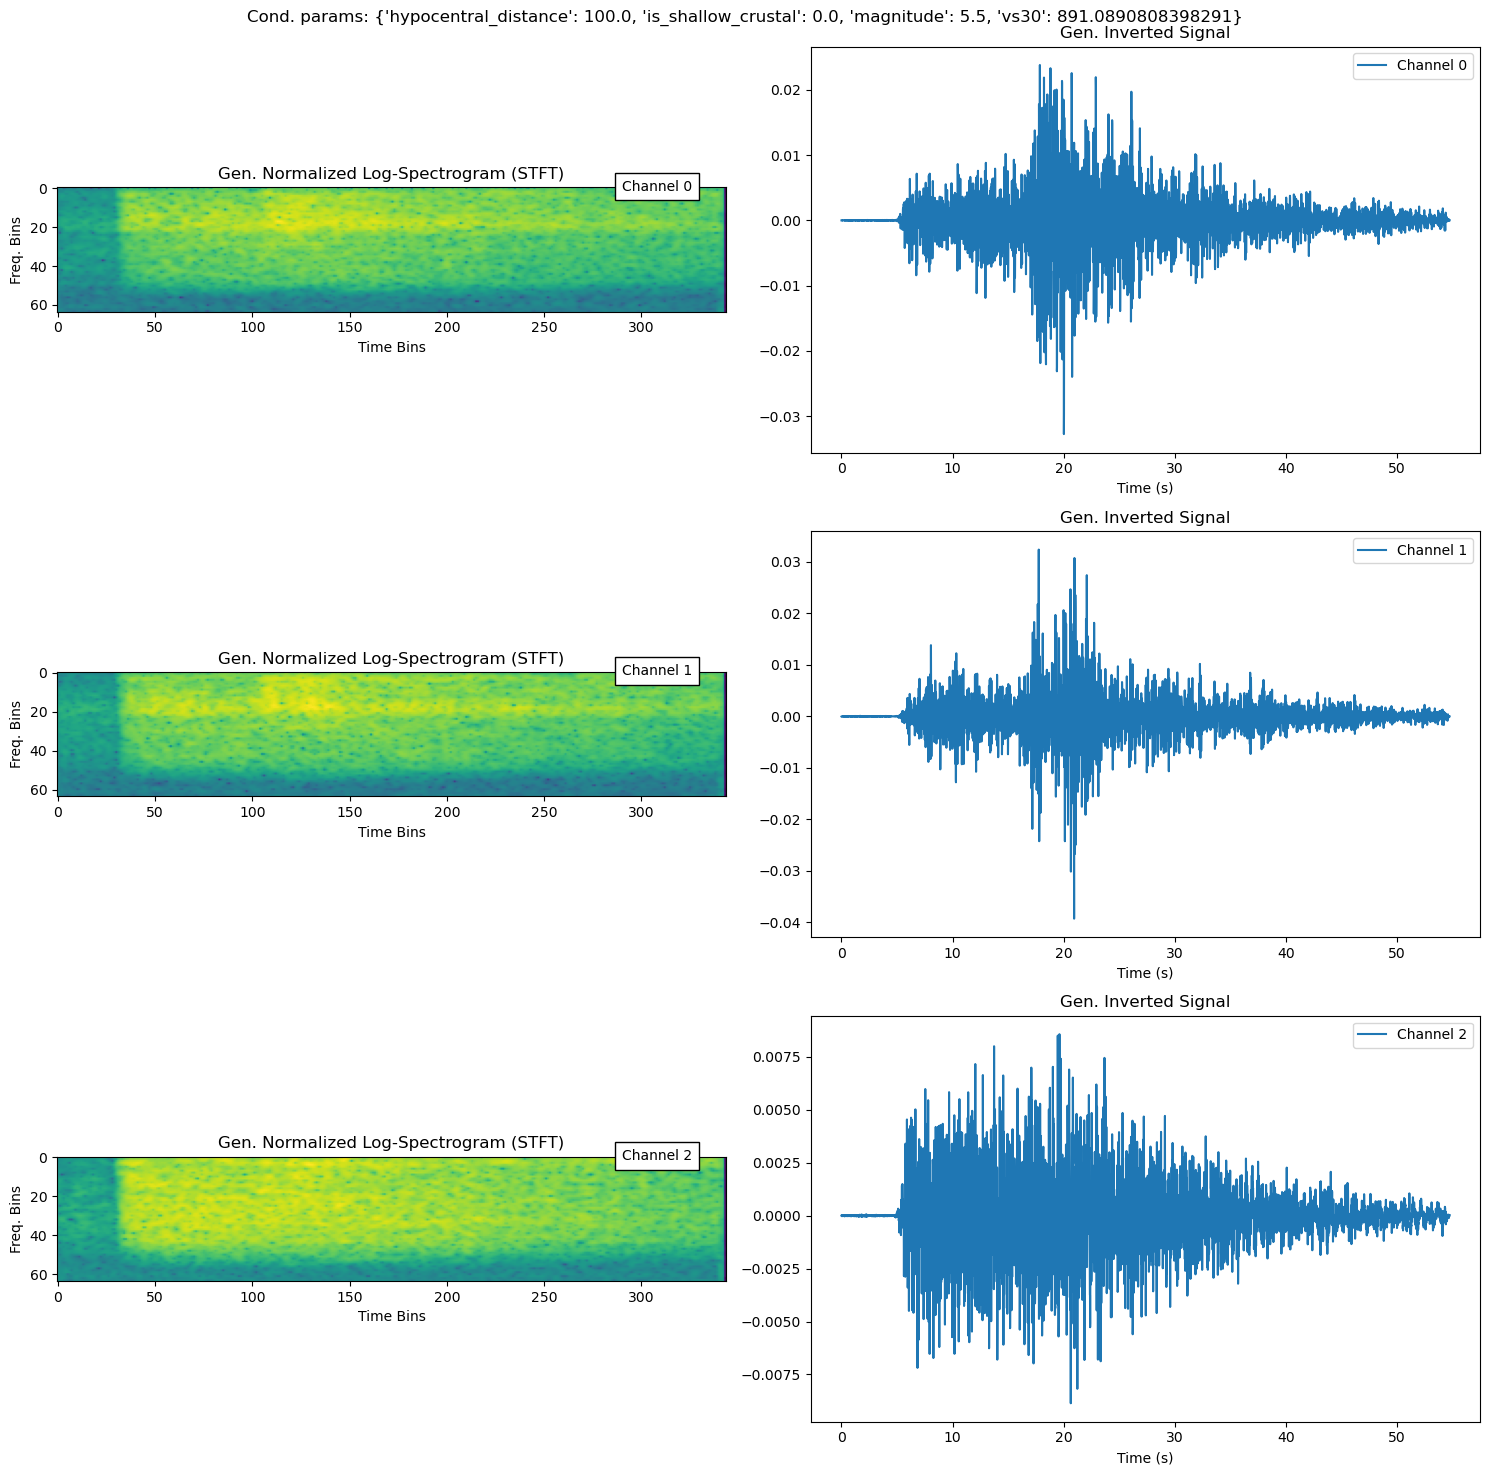

In [17]:
sample_index = 10
plot_raw_waveform(data_raw_wf[sample_index], data_raw['cond'][sample_index], model_data_repr, data_wf[sample_index])

In [18]:
# TODO: works only for 1D signals, need to generalize to 2D signals. However, is only useful for 1D signals.
# max_peak_index = np.argmax(np.max(np.abs(data_raw_wf), axis=(1, 2)))
# plot_raw_waveform(data_raw_wf[max_peak_index], n_channels, data_wf[max_peak_index])

Let's now see the generated waveforms, along with their Power Spectral Density and Log Envelope. 

In [19]:
data = {"waveforms": data_wf, "cond": data_raw['cond']}

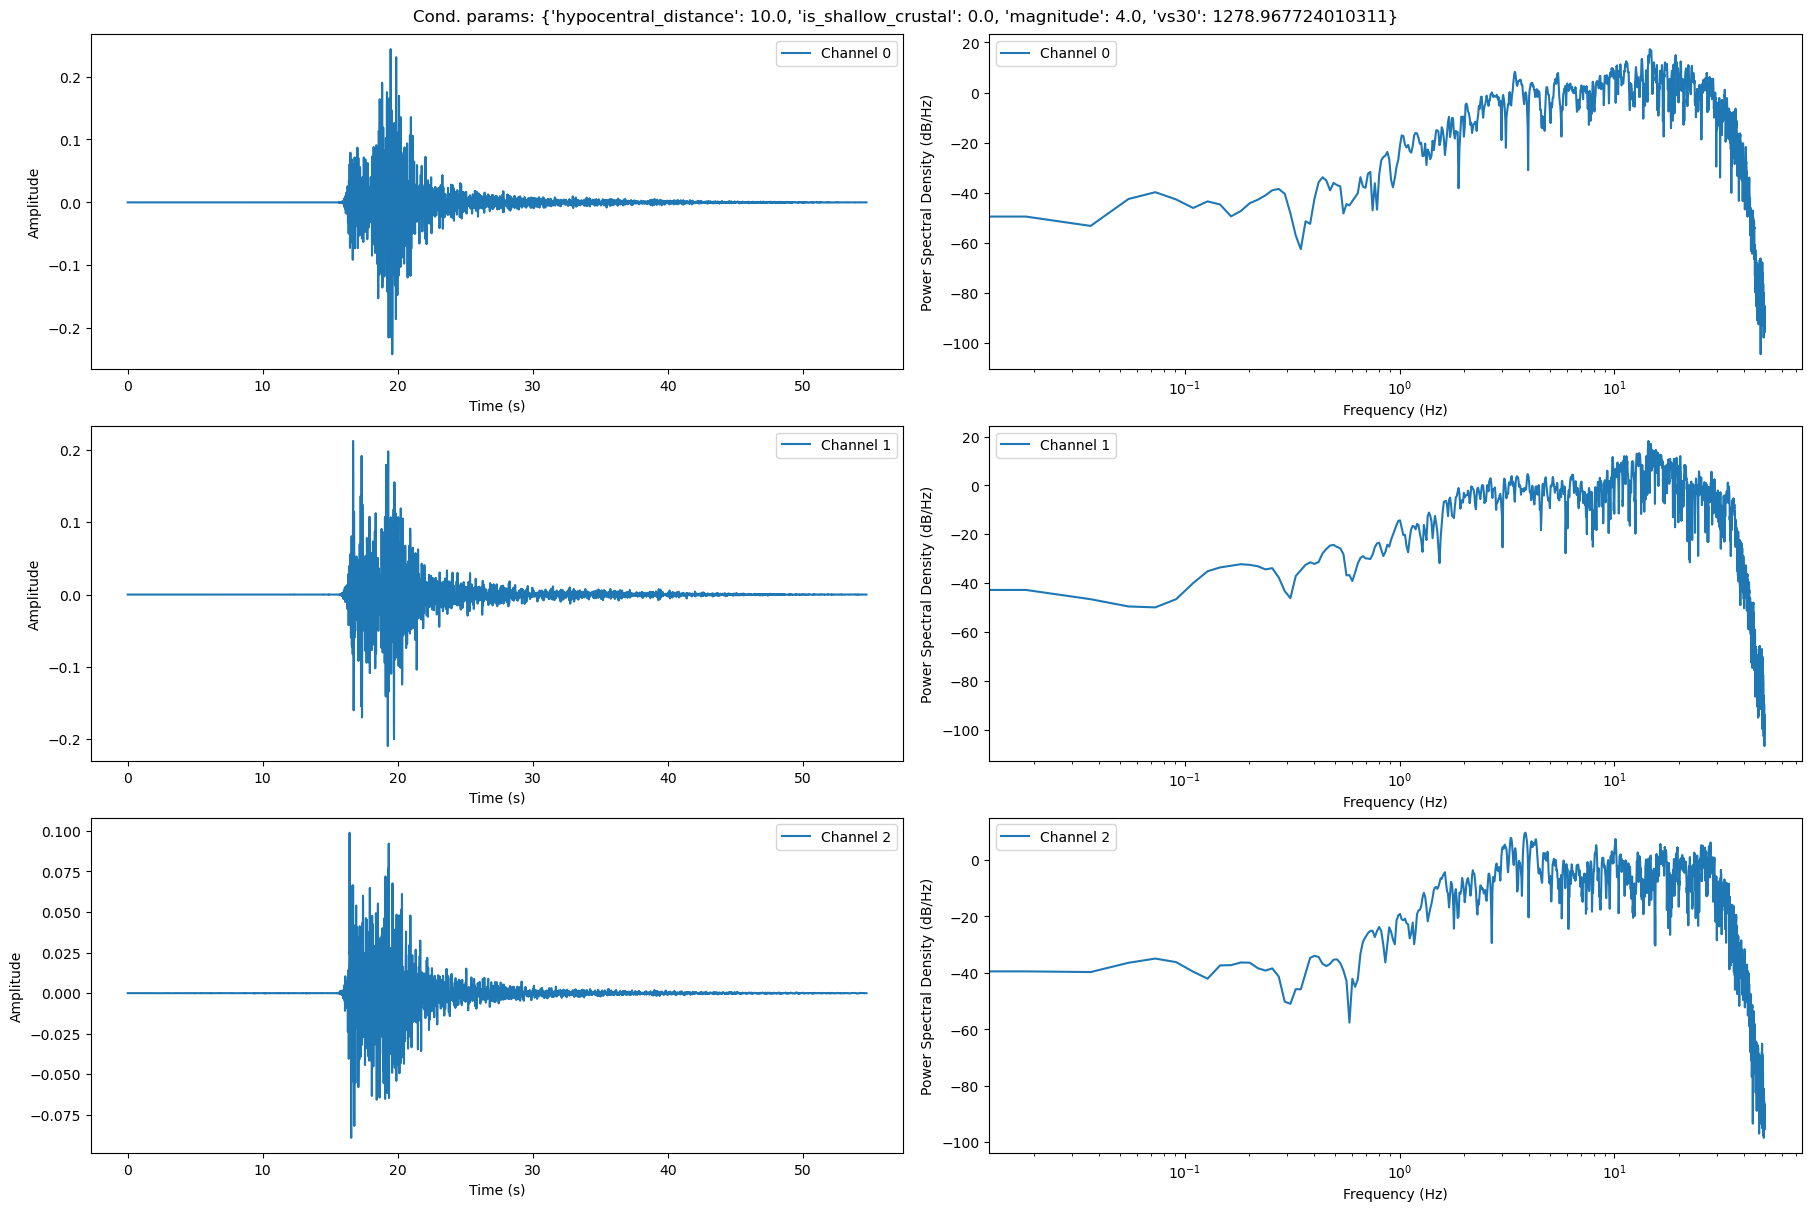

In [20]:
plot_waveform_and_psd(get_samples(data, num_samples=1))

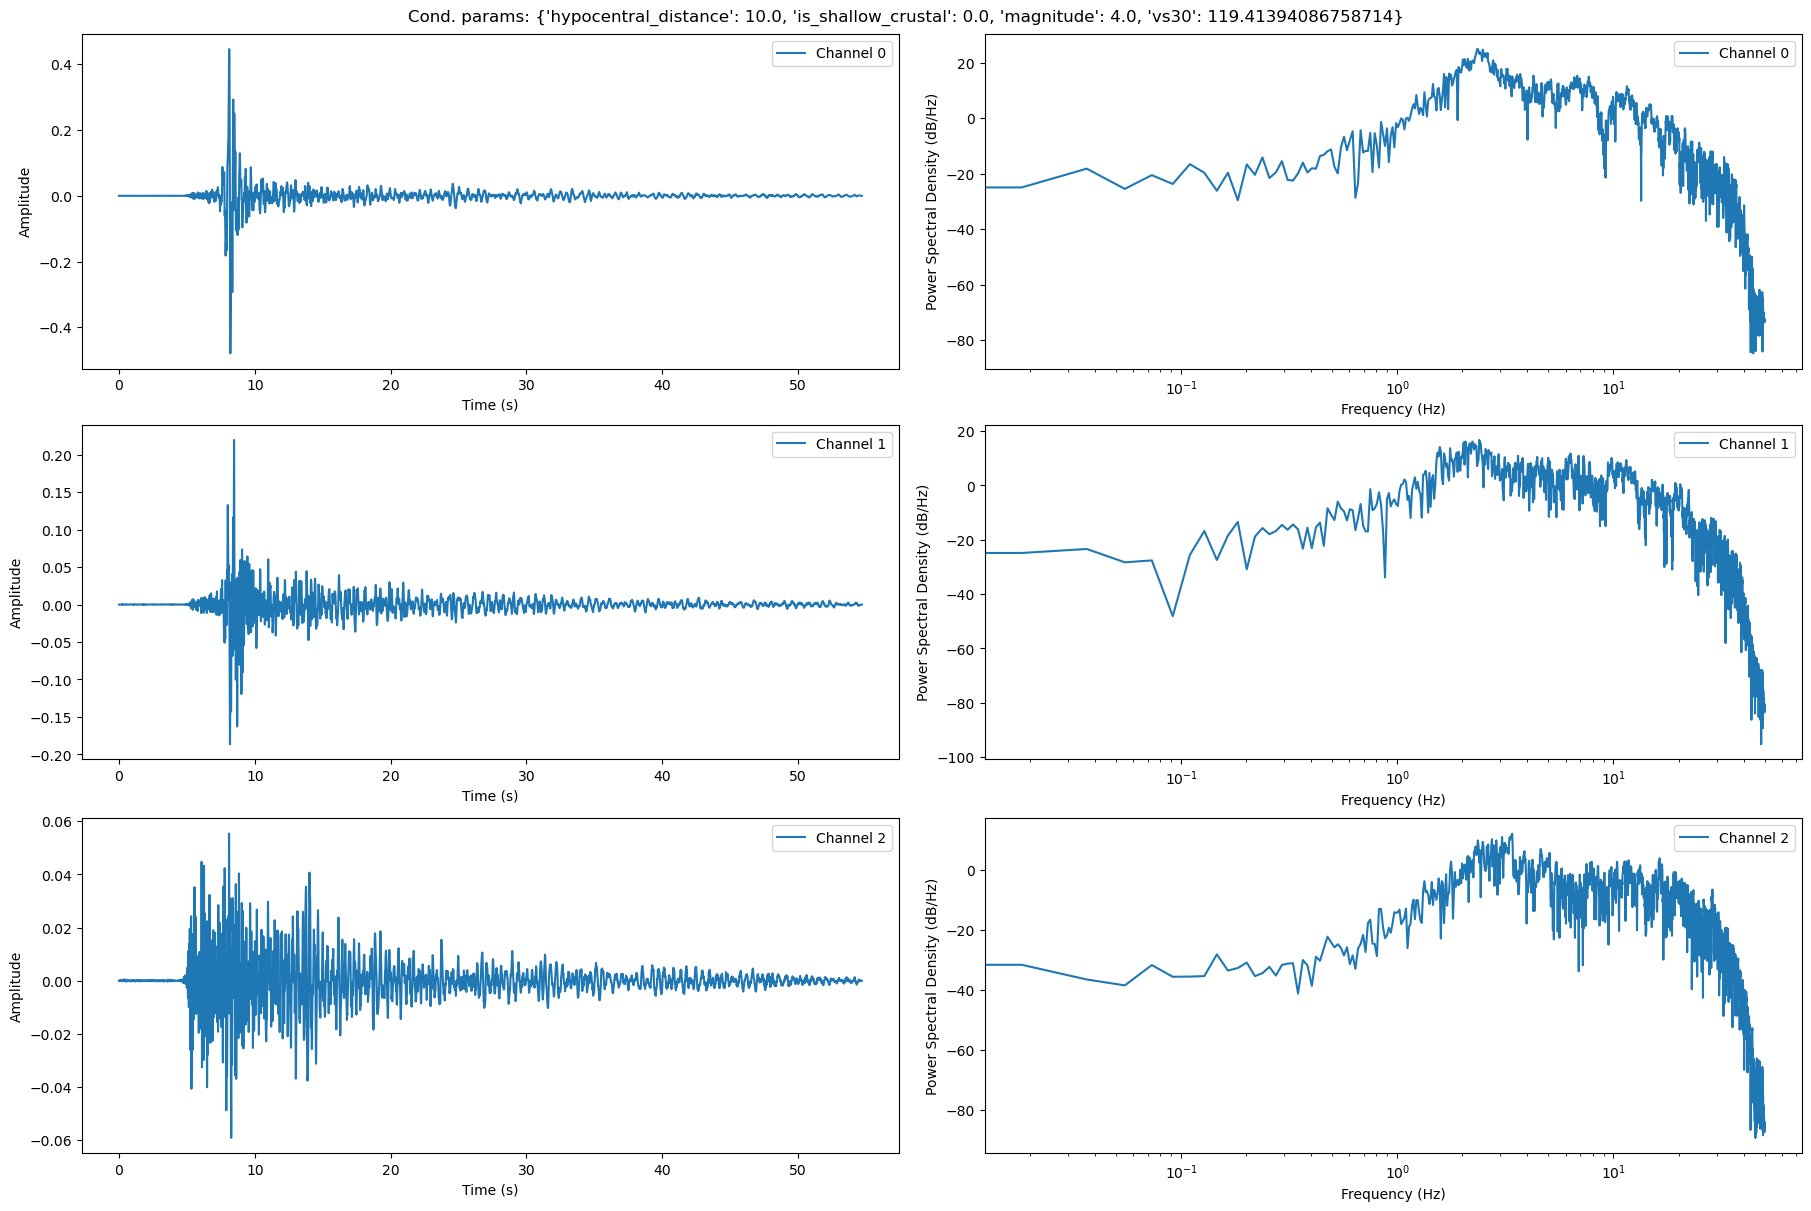

In [21]:
plot_waveform_and_psd(get_samples(data, indexes=[2]))

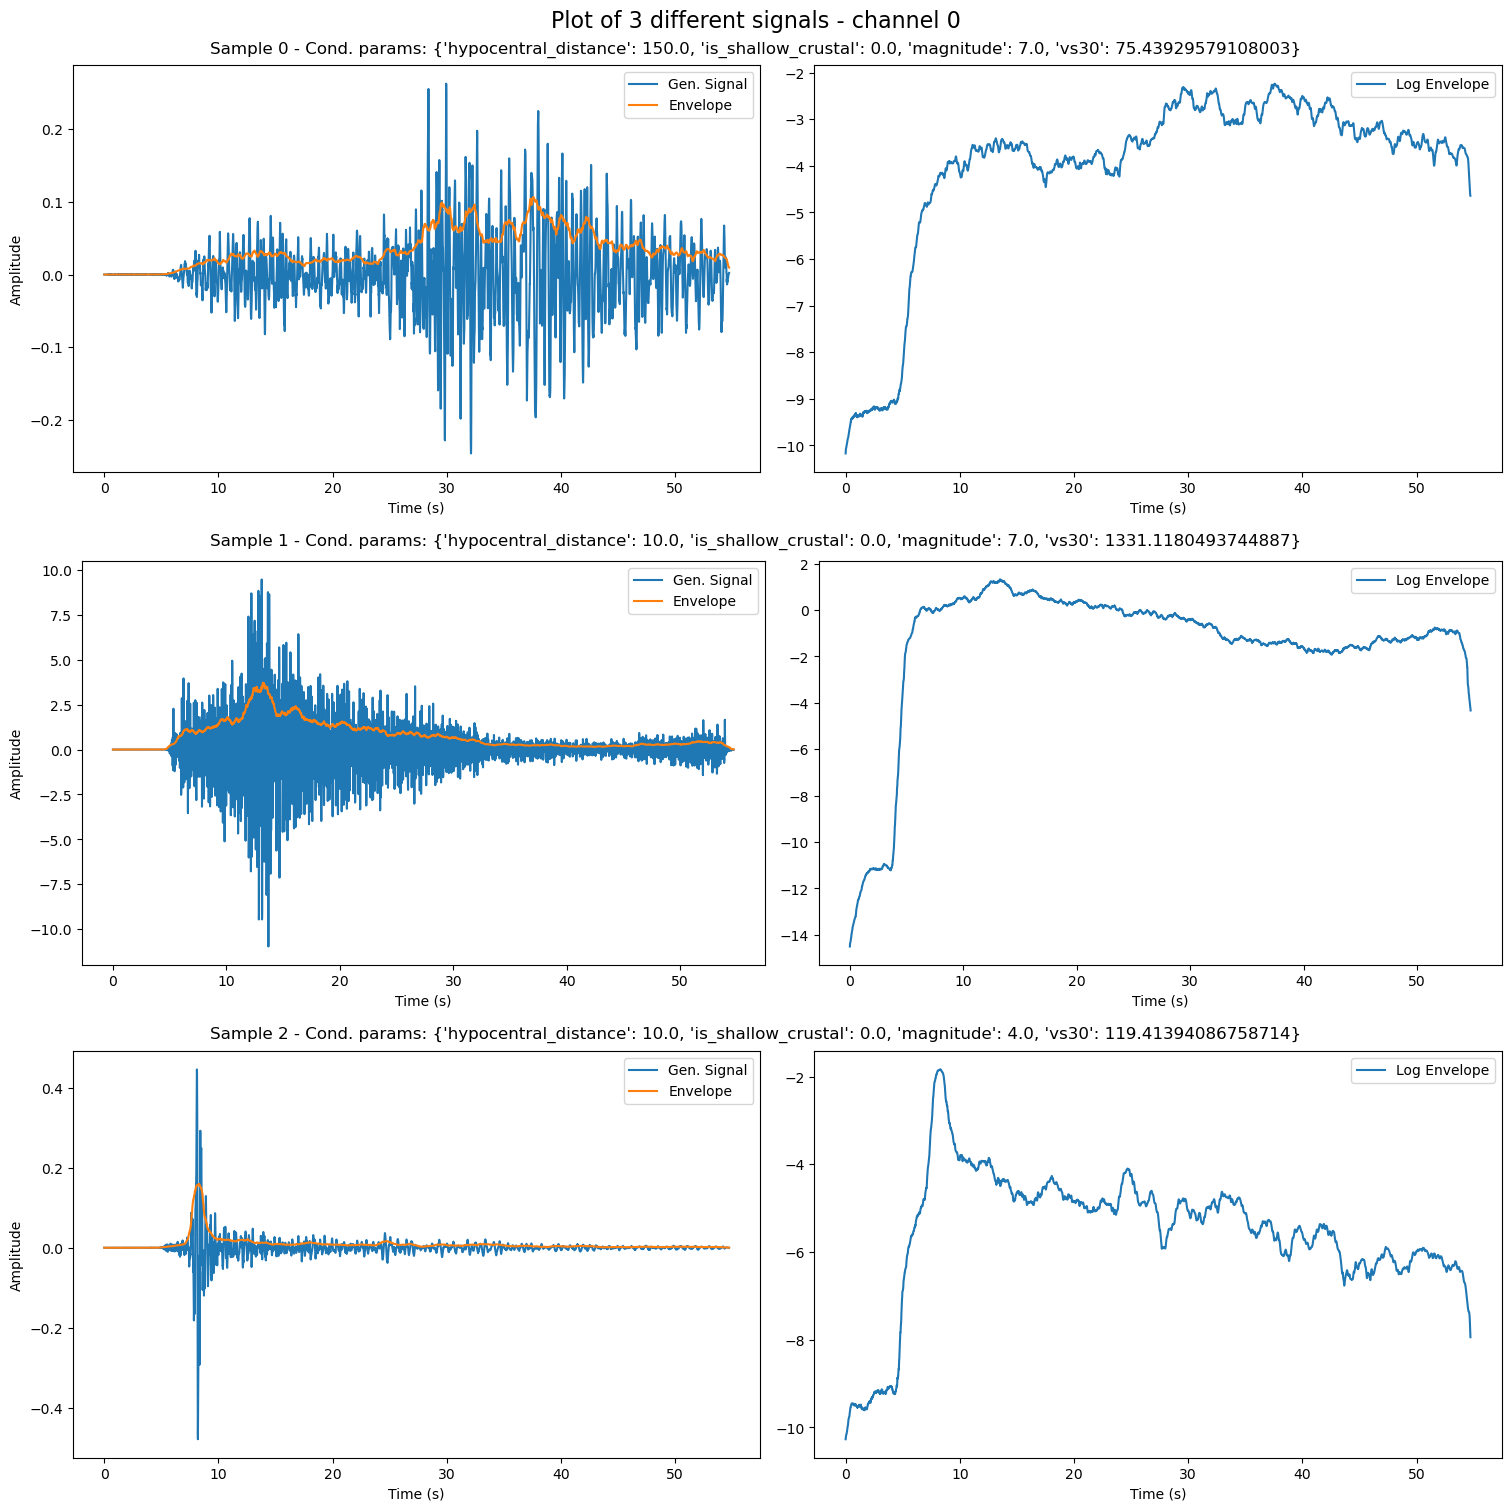

In [22]:
plot_waveforms(get_samples(data, num_samples=3), channel_index=0, plot_log_envelope=True)

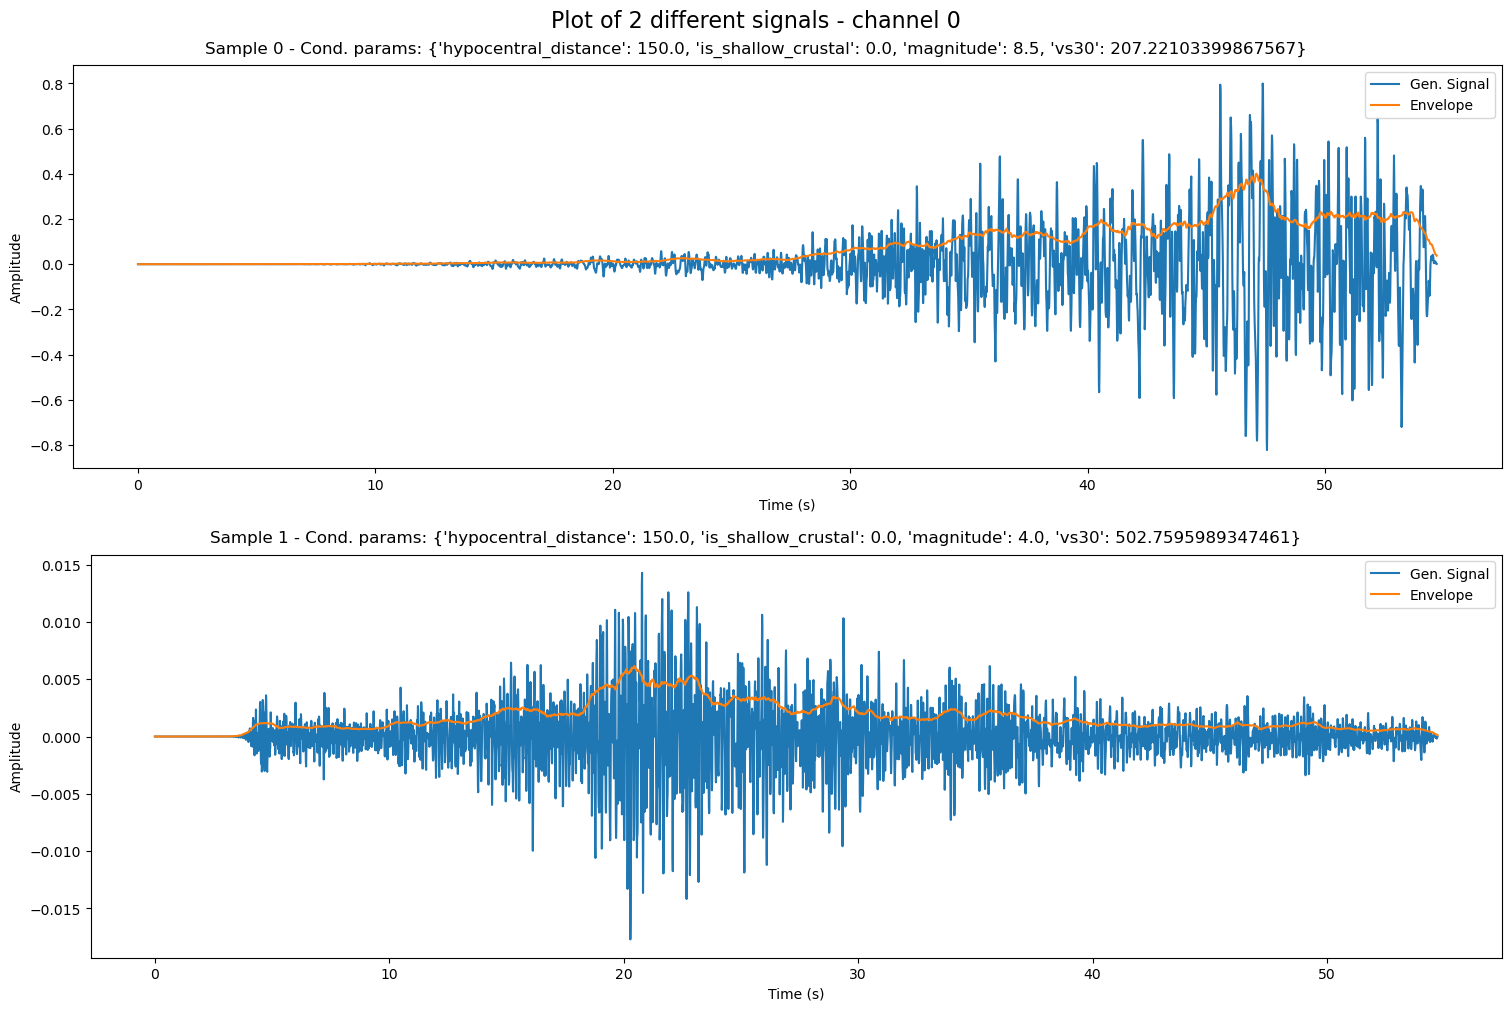

In [23]:
plot_waveforms(get_samples(data, num_samples=2), channel_index=0, plot_log_envelope=False)

## Batch Statistics

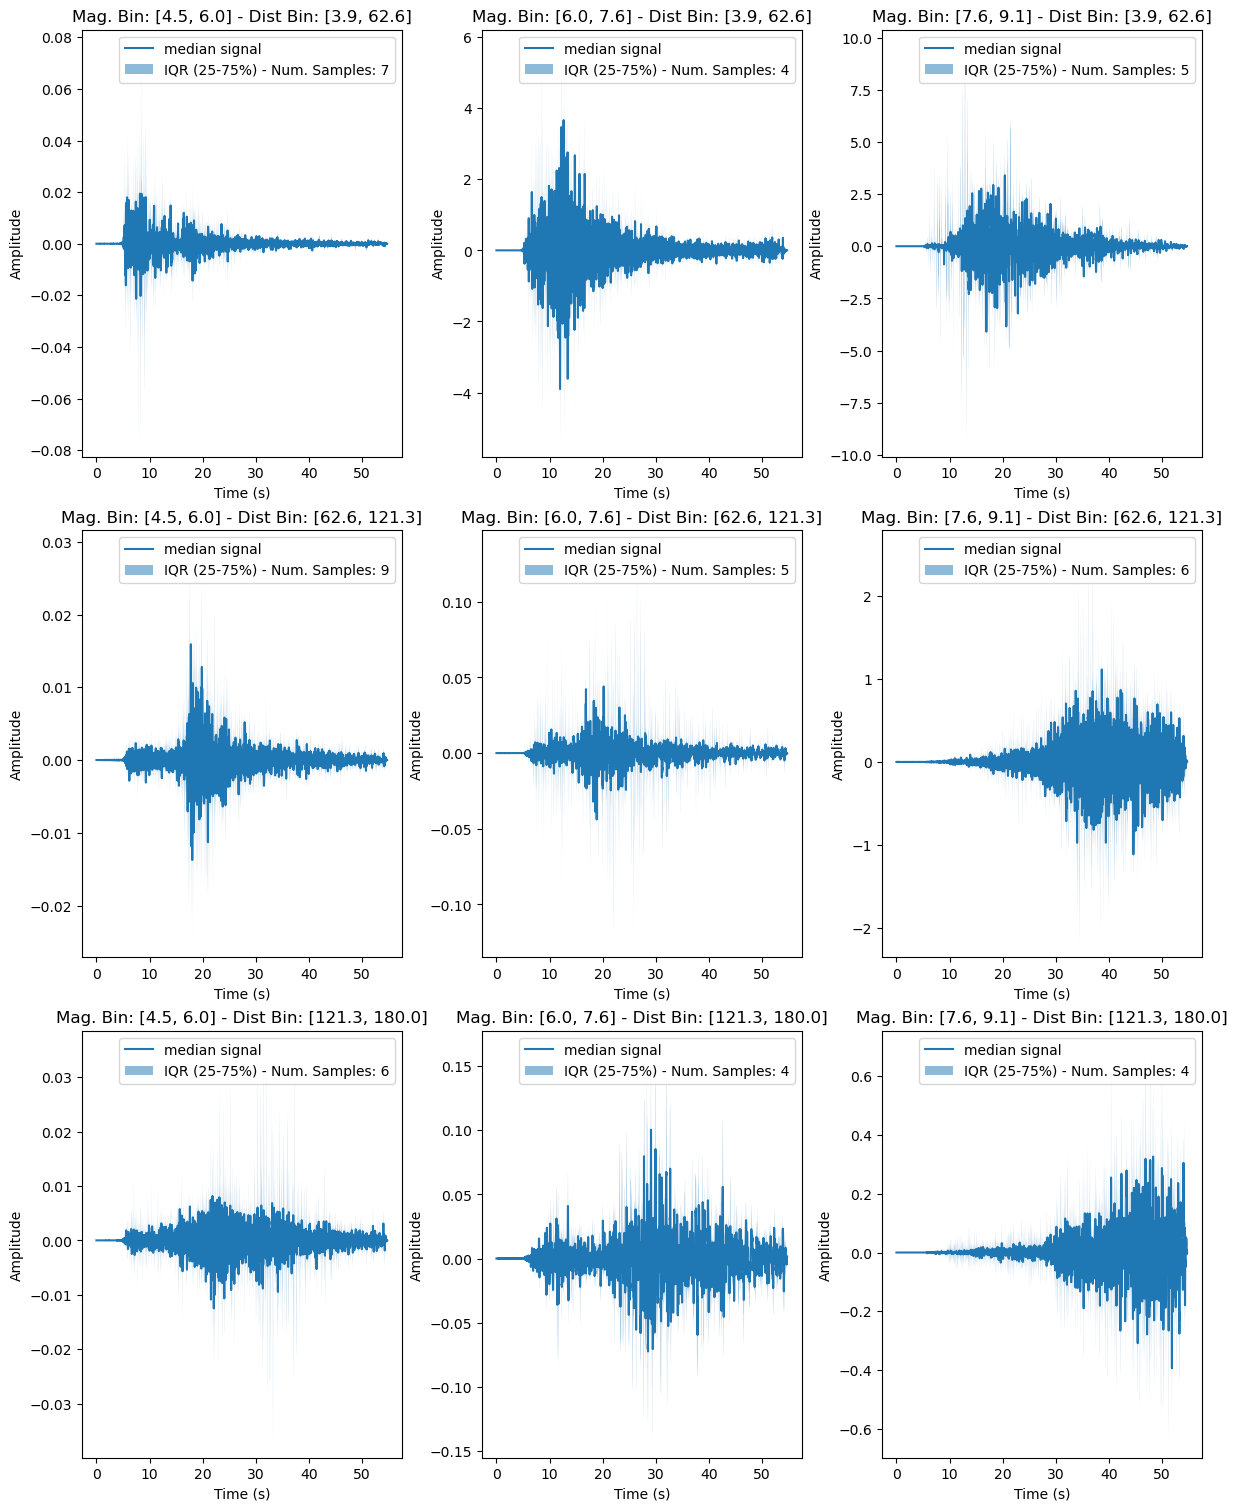

In [24]:
plot_by_bins(data, num_magnitude_bins=3, num_distance_bins=3, plot_type='waveform')

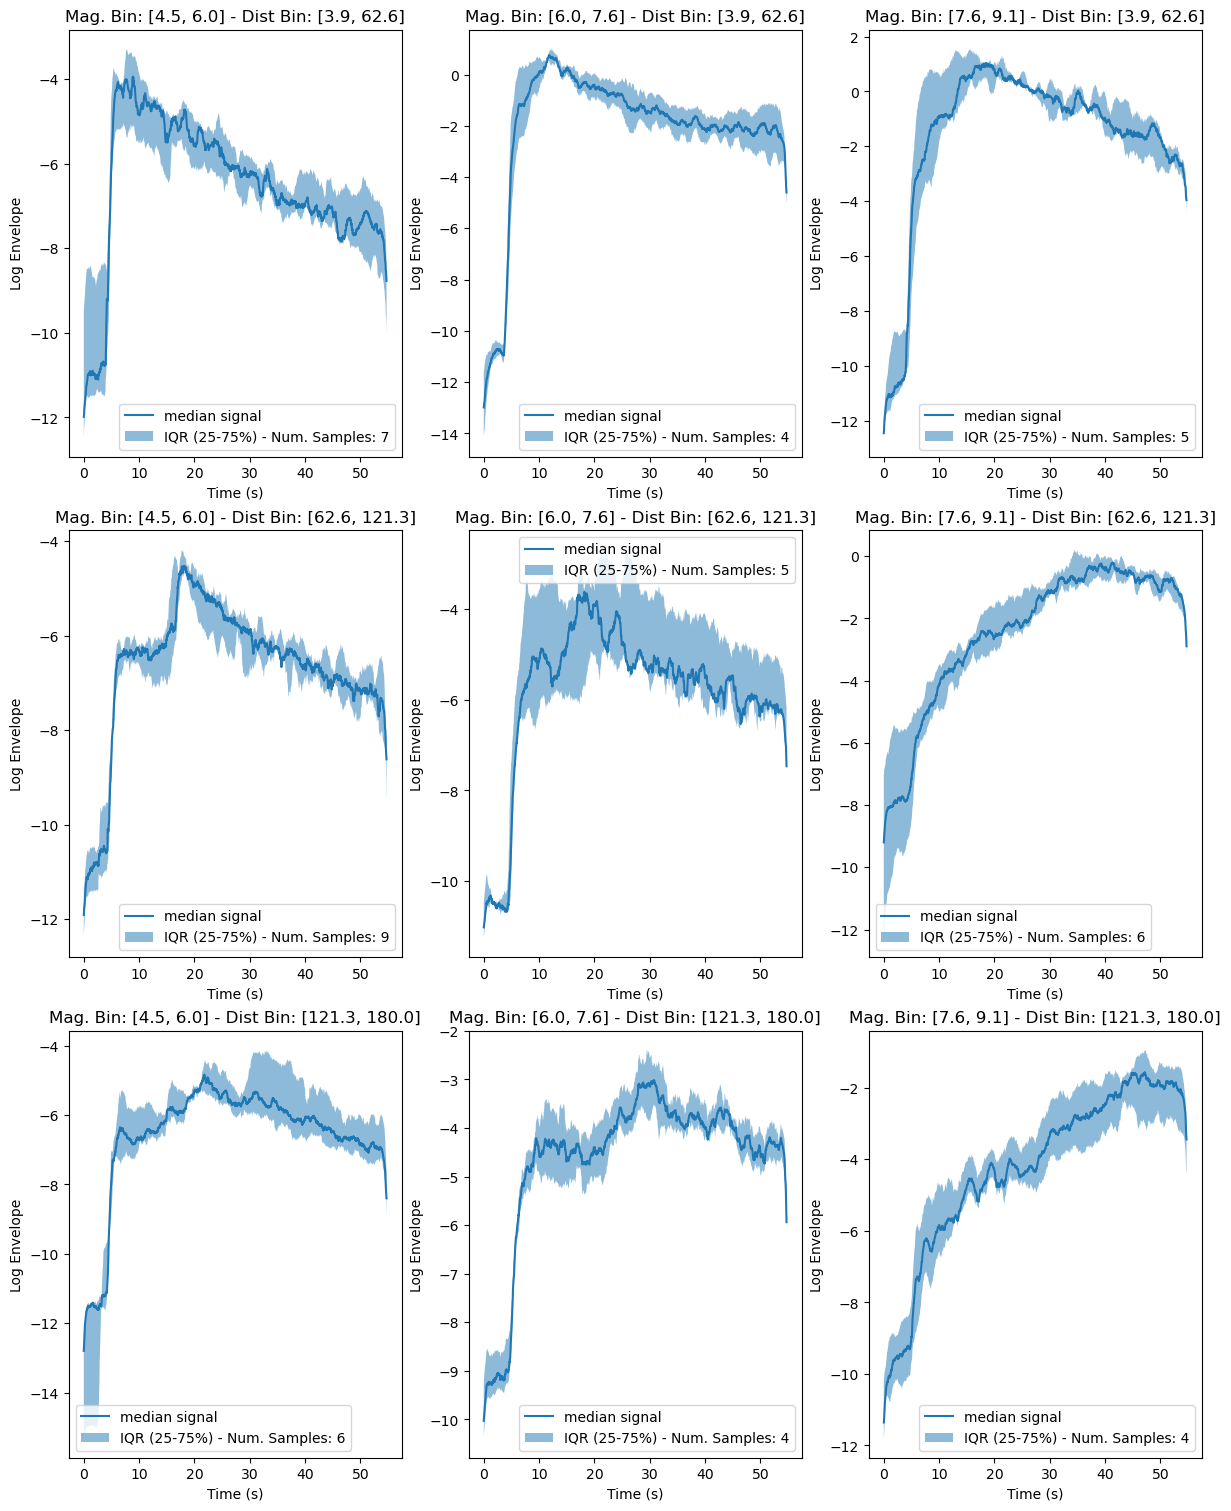

In [25]:
plot_by_bins(data, num_magnitude_bins=3, num_distance_bins=3, plot_type='log_envelope')

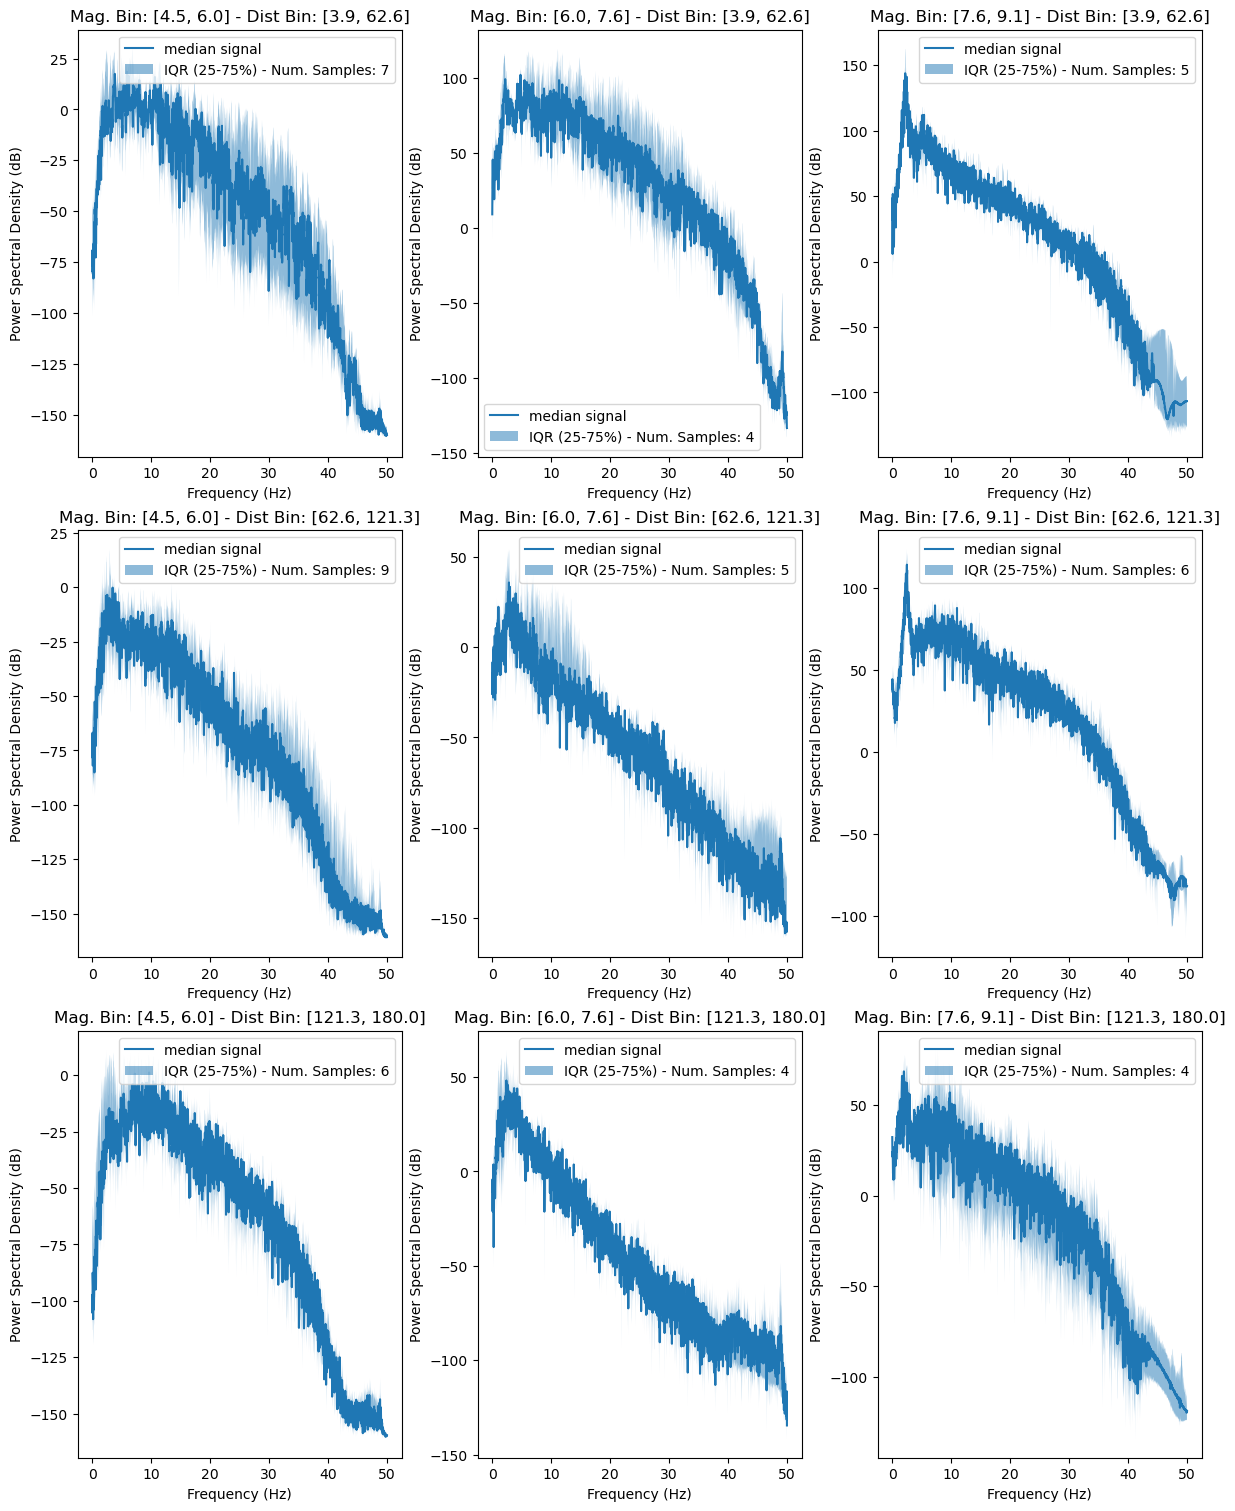

In [26]:
plot_by_bins(data, num_magnitude_bins=3, num_distance_bins=3, plot_type='power_spectral_density')

## Evaluation

In [27]:
from tqdne.dataset import EnvelopeDataset
from torch.utils.data import DataLoader

test_dataset_path = config.datasetdir / config.data_test
test_dataset = EnvelopeDataset(test_dataset_path, model_data_repr, cut=config.signal_length*downsampling, downsample=downsampling)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Let's generate couple of samples with the same conditioning parameters to check the expressiveness of the model and check if it stay within the true data distribution. 

Batch 1/1


100%|██████████| 100/100 [00:10<00:00,  9.52it/s]


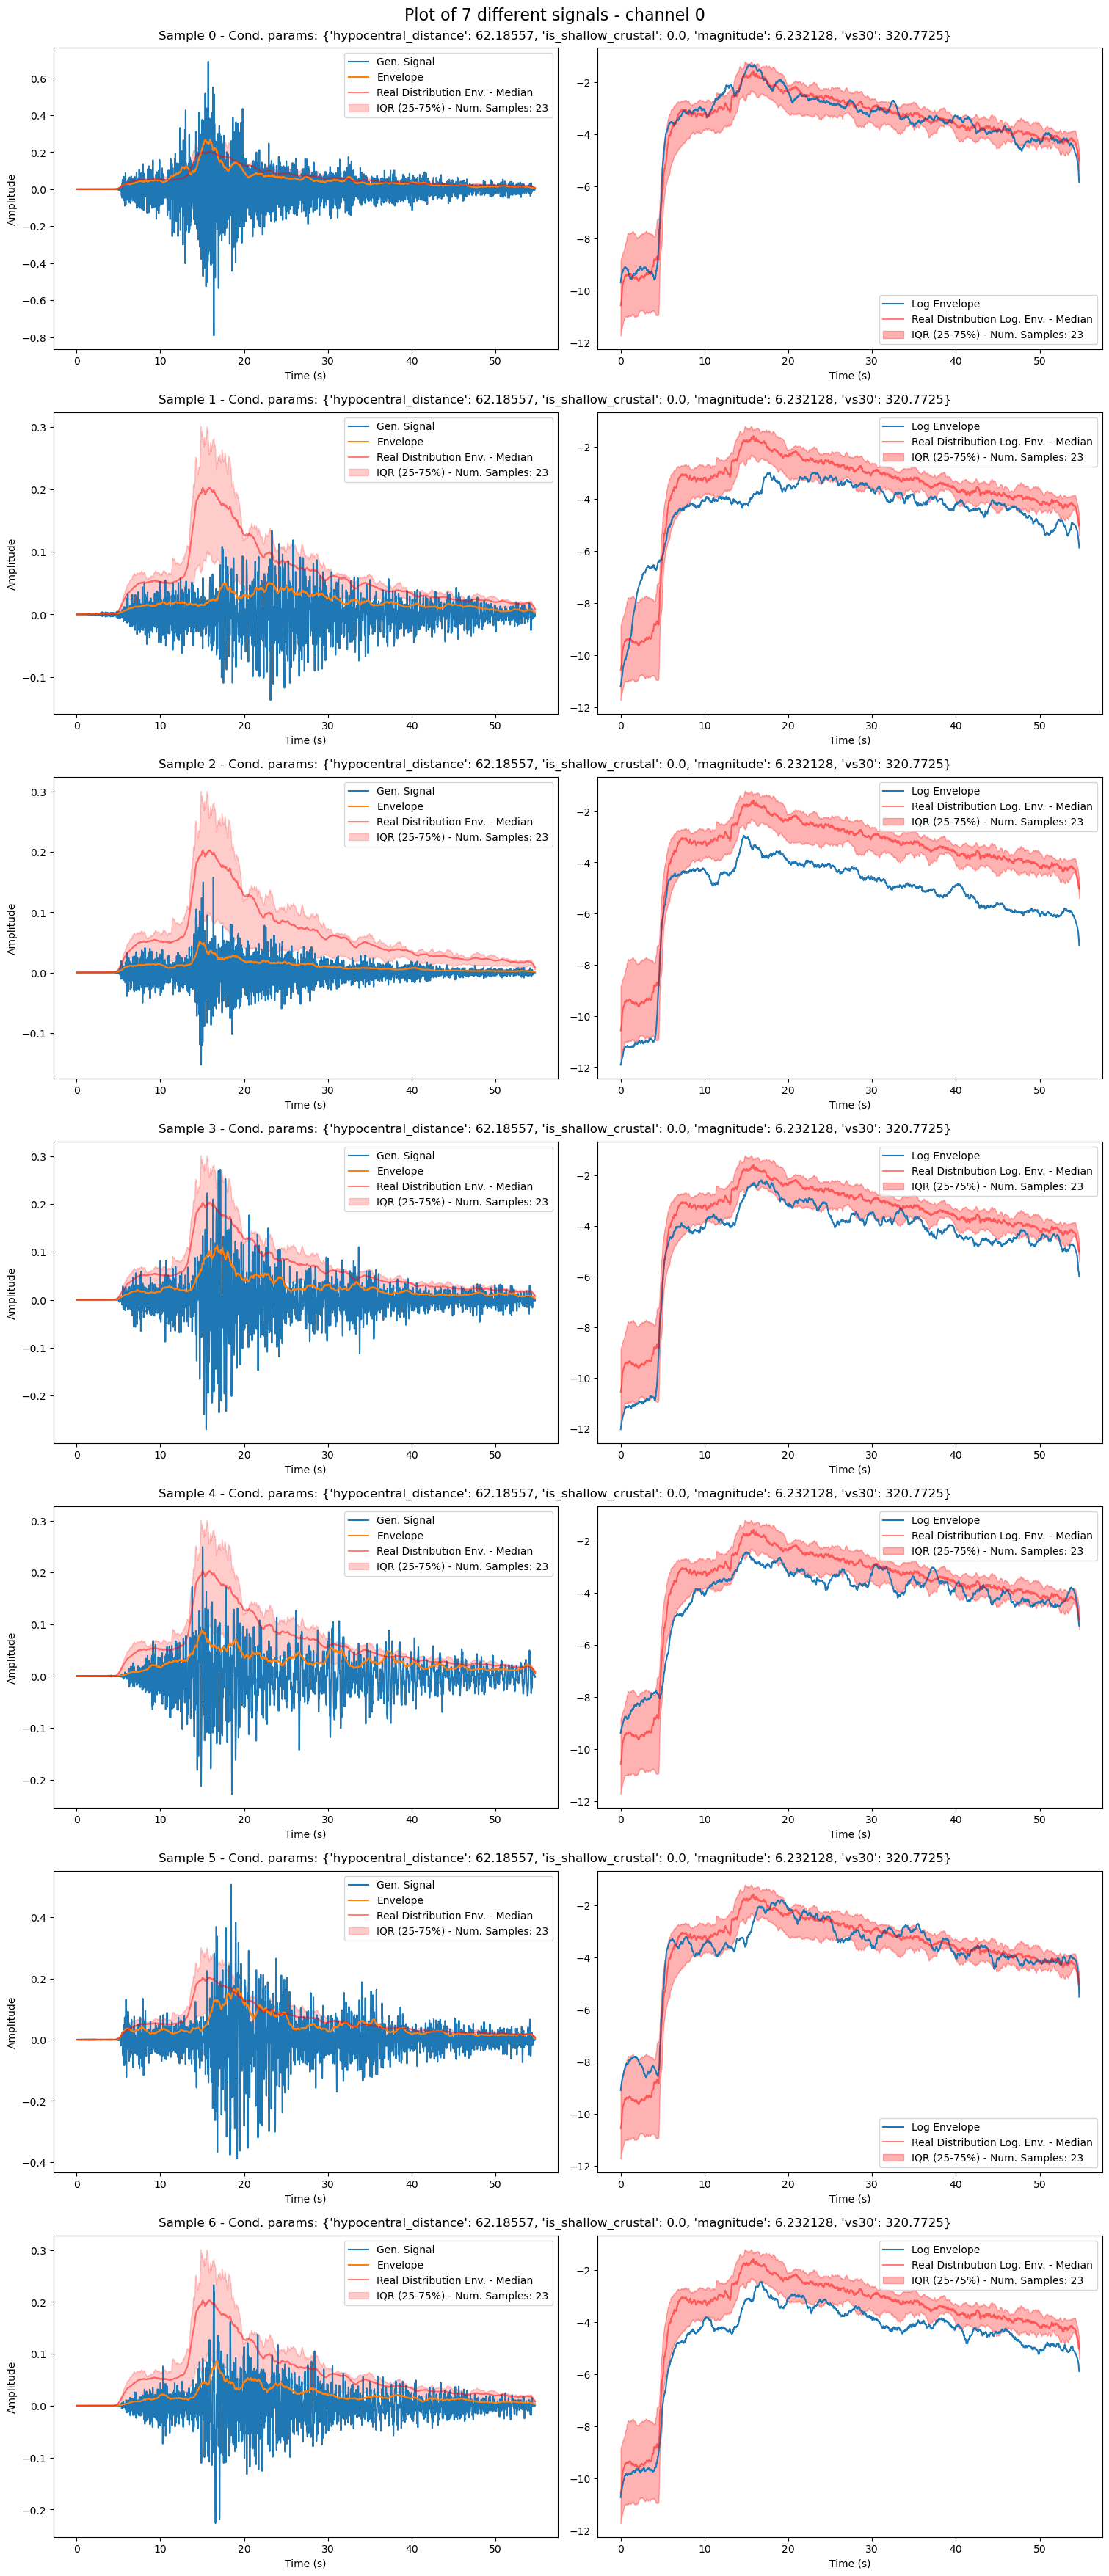

In [28]:
mag_bin = (6, 6.5)
dist_bin = (50, 70)
data_test_single_bin = test_dataset.get_data_by_bins(mag_bin, dist_bin, is_shallow_crustal=0)
cond_params_mean = np.mean(data_test_single_bin['cond'], axis=0).reshape(1,-1)
data_pred_single_bin = generate_data(model, model_data_representation=model_data_repr, raw_output=False, num_samples=7, cond_input=cond_params_mean, device=device.type, max_batch_size=batch_size)

plot_waveforms(data_pred_single_bin, test_waveforms=data_test_single_bin['waveforms'])

Batch 1/1


100%|██████████| 100/100 [00:10<00:00,  9.56it/s]


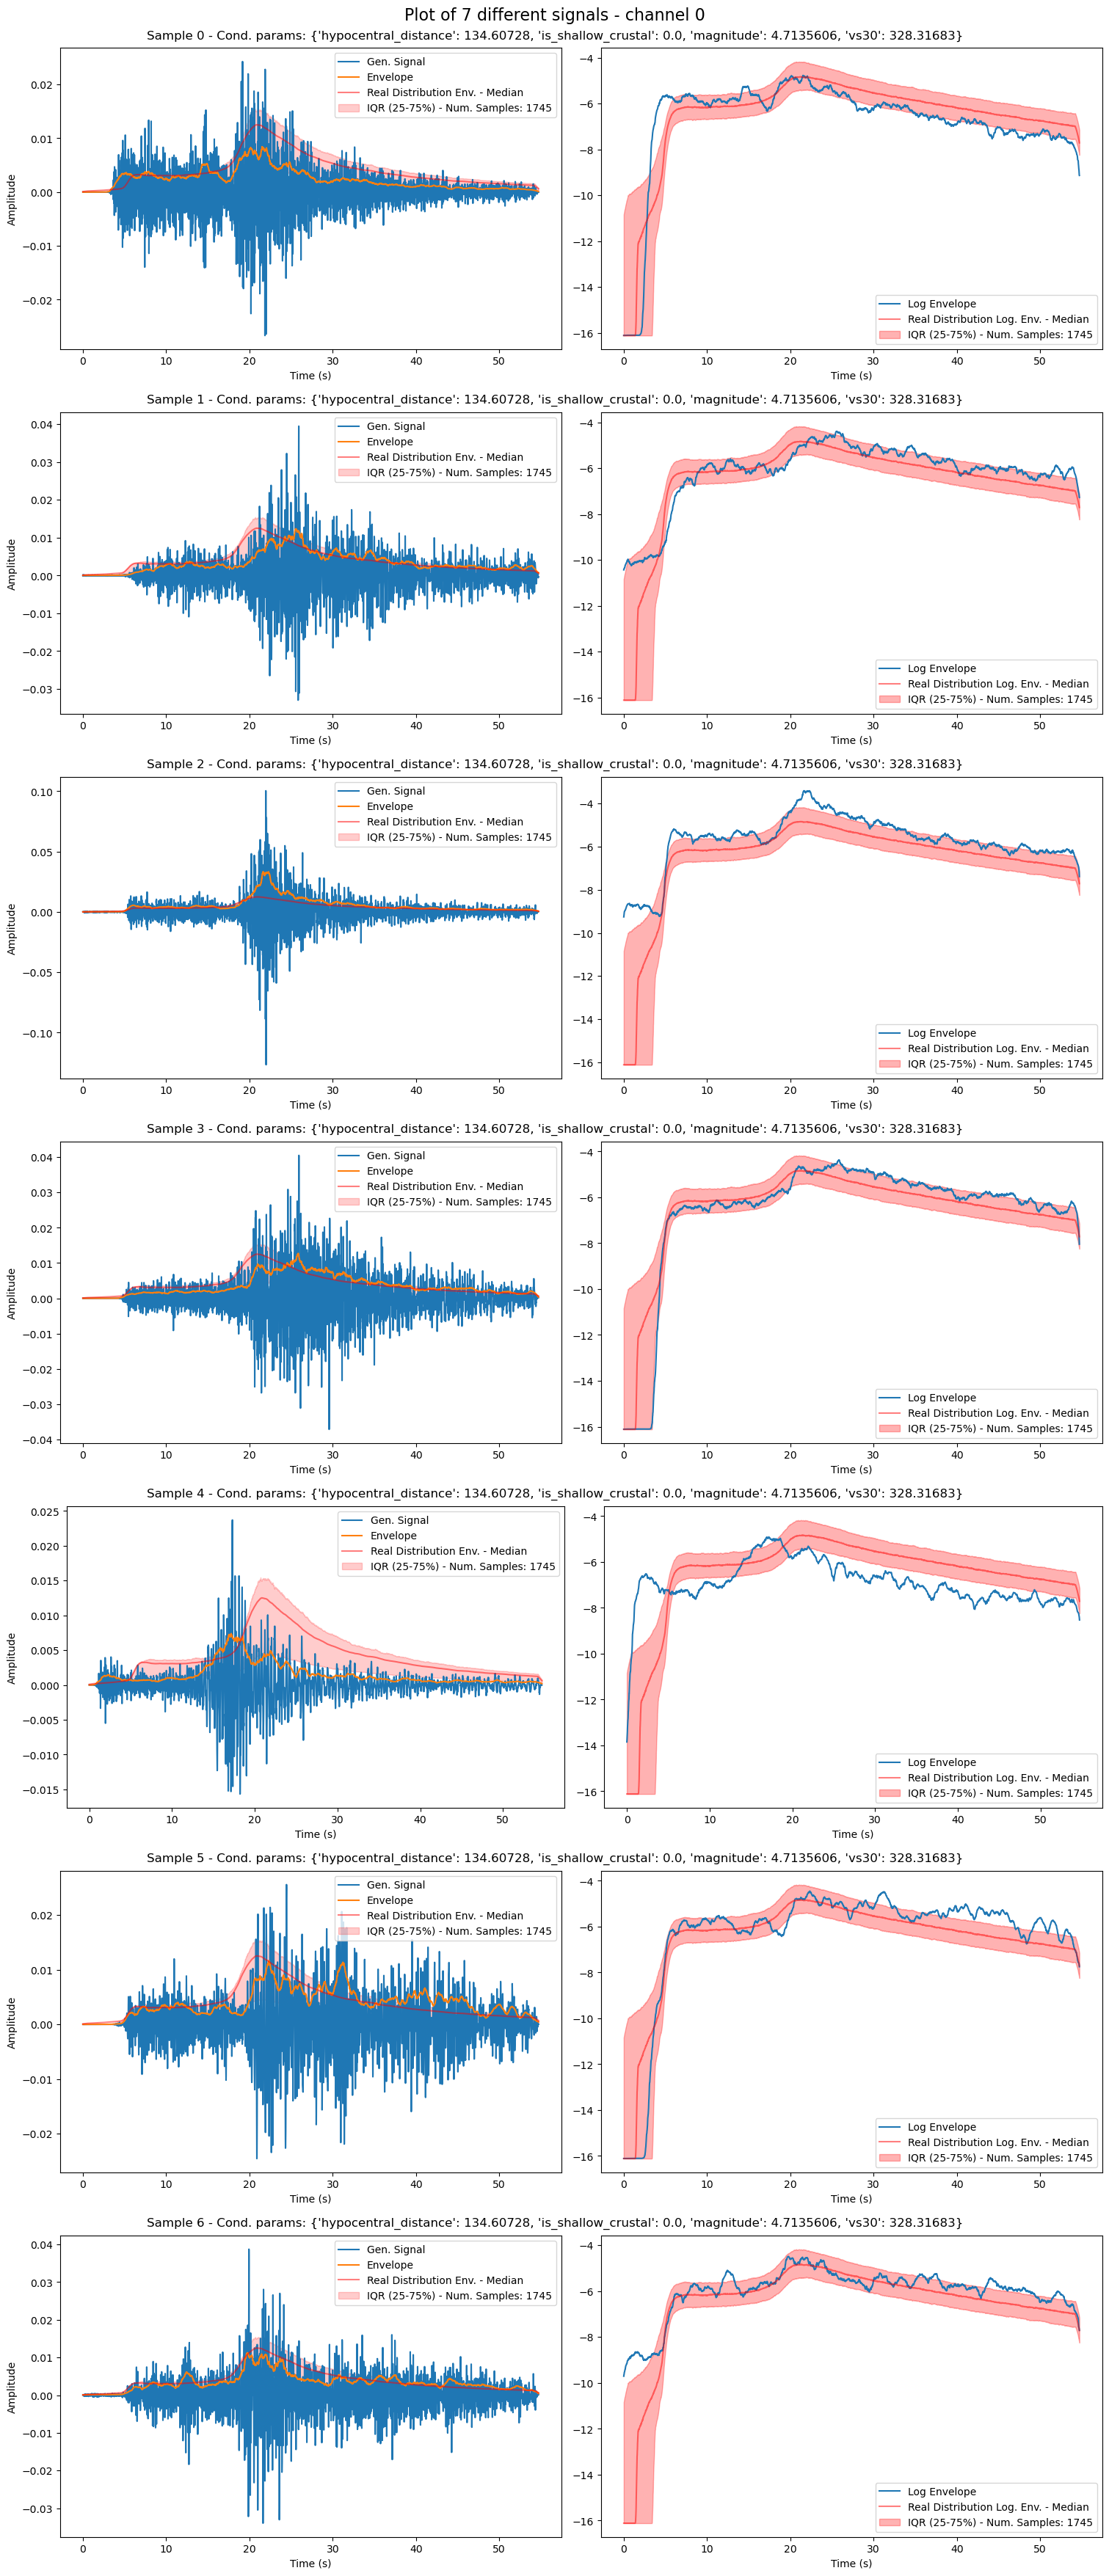

In [29]:
mag_bin = (4, 5)
dist_bin = (120, 150)
data_test_single_bin = test_dataset.get_data_by_bins(mag_bin, dist_bin, is_shallow_crustal=0)
cond_params_mean = np.mean(data_test_single_bin['cond'], axis=0).reshape(1,-1)
data_pred_single_bin = generate_data(model, model_data_representation=model_data_repr, raw_output=False, num_samples=7, cond_input=cond_params_mean, device=device.type, max_batch_size=batch_size)

plot_waveforms(data_pred_single_bin, test_waveforms=data_test_single_bin['waveforms'])

Let's now compare the statistics of the generated data wrt the test data.

In [30]:
# Load test data
test_cond = []
test_raw_waveforms = []
for i, batch in enumerate(test_dataloader):
    test_raw_waveforms.append(to_numpy(batch['repr']))
    test_cond.append(to_numpy(batch['cond']))
test_raw_waveforms = np.concatenate(test_raw_waveforms, axis=0)
test_waveforms = model_data_repr.invert_representation(test_raw_waveforms)
test_cond = np.concatenate(test_cond, axis=0)

test_data = {"waveforms": test_waveforms, "cond": test_cond}

test_waveforms.shape, test_cond.shape    

((15990, 3, 5472), (15990, 4))

Now let's generate more samples to perform an analysis by dividing the data in bins (magnitude and distance). 

In [ ]:
# Generate waveforms with the same conditioning parameters of the test data
generated_raw_data = generate_data(model, model_data_repr, raw_output=True, num_samples=test_cond.shape[0], cond_input=test_cond, device=device.type, max_batch_size=batch_size)
generated_raw_data['waveforms'].shape, generated_raw_data['cond'].shape

Batch 1/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 2/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 3/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 4/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 5/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 6/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 7/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 8/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 9/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 10/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 11/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 12/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 13/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 14/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 15/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 16/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 17/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 18/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 19/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 20/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 21/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 22/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 23/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 24/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 25/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 26/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 27/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 28/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 29/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 30/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 31/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 32/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 33/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 34/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 35/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 36/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 37/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 38/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 39/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 40/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 41/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 42/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 43/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 44/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 45/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 46/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 47/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 48/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 49/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 50/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 51/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 52/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 53/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 54/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 55/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 56/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 57/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 58/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 59/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 60/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 61/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 62/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 63/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 64/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 65/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 66/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 67/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 68/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 69/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 70/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 71/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 72/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 73/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 74/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 75/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 76/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 77/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 78/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 79/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 80/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 81/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 82/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 83/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 84/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 85/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 86/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 87/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 88/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 89/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 90/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 91/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 92/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 93/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 94/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 95/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 96/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 97/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 98/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 99/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 100/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 101/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 102/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 103/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 104/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 105/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 106/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 107/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 108/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 109/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 110/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 111/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 112/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 113/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 114/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 115/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 116/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 117/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 118/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 119/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 120/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 121/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 122/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 123/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 124/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 125/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 126/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 127/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 128/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 129/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 130/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 131/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 132/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 133/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 134/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 135/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 136/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 137/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 138/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 139/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 140/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 141/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 142/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 143/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 144/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 145/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 146/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 147/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 148/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 149/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 150/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 151/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 152/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 153/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 154/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 155/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 156/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 157/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 158/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 159/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 160/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 161/319


100%|██████████| 100/100 [00:32<00:00,  3.04it/s]


Batch 162/319


 91%|█████████ | 91/100 [00:29<00:02,  3.01it/s]

Let's check the raw outputs by comparing them statistically with real data in the representation domain. 

In [ ]:
plot_raw_output_distribution(generated_raw_data["waveforms"], test_raw_waveforms, model_data_repr)

In [ ]:
generated_data = {"waveforms": model_data_repr.invert_representation(generated_raw_data['waveforms']), "cond": generated_raw_data['cond']}
generated_data['waveforms'].shape, generated_data['cond'].shape

Let's save the generated data and the test data for future use.

The data will be saved in the same place of the checkpoint of the selected model, with the same name of `ckpt`, except for the extension of the file (saved as a pickle `.pkl` file).
The best way to download the generated dataset locally is to replace `pkl_filename` with the desired filename to store it in the current directory, and then download it using the visual interface of VSCode or JupyterLab. 


The data is saved as a `dict` with keys `waveforms` and `cond`.

In [ ]:
import pickle

# If some data is already saved, load it
pkl_filename = f"{str(ckpt).replace('.ckpt', '.pkl')}"
pkl_filepath = Path(pkl_filename)
read_only = not "generated_data" in globals()
if os.path.exists(pkl_filepath):
    with open(pkl_filepath,'rb') as f:
        pred_data_f = pickle.load(f)
        if not read_only:
            generated_data['waveforms'] = np.concatenate([pred_data_f['waveforms'], generated_data['waveforms']])
            generated_data['cond'] = np.concatenate([pred_data_f['cond'], generated_data['cond']])
        else:
            generated_data = {"waveforms": pred_data_f['waveforms'], "cond": pred_data_f['cond']}

# Store the generated data only  
if not read_only:      
    with open(pkl_filepath,'wb') as f: pickle.dump(generated_data, f)
print(pkl_filepath)
generated_data['waveforms'].shape, generated_data['cond'].shape

And let's now compare the generated data against the test ones. 

In [ ]:
plot_bins(
    plot_type='log_envelope',
    distance_bins = [(0, 40), (40, 60), (60, 80), (80.0, 120.), (120., 150.), (150., 200.)],
    magnitude_bins = [(4.5, 5.0), (5., 5.5), (5.5, 6.0), (6.0, 7.0), (7.0, 9.0)], 
    channel_index=0,
    test_data = test_data, 
    data = generated_data, 
    model = model,
     model_data_representation = model_data_repr
)

In [ ]:
plot_bins(
    plot_type='power_spectral_density',
    distance_bins = [(0, 40), (40, 60), (60, 80), (80.0, 120.), (120., 150.), (150., 200.)],
    magnitude_bins = [(4.5, 5.0), (5., 5.5), (5.5, 6.0), (6.0, 7.0), (7.0, 9.0)], 
    channel_index=0,
    test_data = test_data, 
    data = generated_data, 
    model = model,
     model_data_representation = model_data_repr
)

Visualize the whole distribution in terms of Power Spectral Density and Envelope. 

In [ ]:
from tqdne.plot import PowerSpectralDensityPlot, BinPlot
from tqdne.metric import PowerSpectralDensity

psd_metrics = [PowerSpectralDensity(fs, channel=channel, invert_representation=False) for channel in range(n_channels)]
psd_plots = [PowerSpectralDensityPlot(fs, channel, invert_representation=False) for channel in range(n_channels)]
for i, psd in enumerate(psd_metrics):
    psd_plots[i](preds=generated_data['waveforms'], target=test_data['waveforms'][:, :, :signal_length], cond=test_data['cond'])
    psd(preds=generated_data['waveforms'], target=test_data['waveforms'][:, :, :signal_length])    
    psd_bin = BinPlot(psd, num_mag_bins=10, num_dist_bins=10)
    psd_bin(preds=generated_data['waveforms'], target=test_data['waveforms'][:, :, :signal_length], cond=test_data['cond']).show()
       

In [ ]:
from tqdne.plot import LogEnvelopePlot, BinPlot
from tqdne.metric import LogEnvelope

logenv_metrics = [LogEnvelope(channel=channel, invert_representation=False) for channel in range(n_channels)]
logenv_plots = [LogEnvelopePlot(fs=fs, channel=channel, invert_representation=False) for channel in range(n_channels)]
for i, logenv in enumerate(logenv_metrics):
    logenv_plots[i](preds=generated_data['waveforms'], target=test_data['waveforms'][:, :, :signal_length], cond=test_data['cond'])
    logenv(preds=generated_data['waveforms'], target=test_data['waveforms'][:, :, :signal_length])    
    logenv_bin = BinPlot(logenv, num_mag_bins=10, num_dist_bins=10)
    logenv_bin(preds=generated_data['waveforms'], target=test_data['waveforms'][:, :, :signal_length], cond=test_data['cond']).show()

### Evaluation using a classifier

In [ ]:
classifier_path = Path("/users/abosisio/scratch/tqdne/outputs/classifier-2D-32Chan-(1, 2, 4, 8)Mult-2ResBlocks-4AttHeads_LogSpectrogram-stft_ch:128-hop_size:32/name=0_epoch=19-val_loss=1.02.ckpt")
classifier, classifier_data_repr, classifier_ckpt = load_model(classifier_path, use_ddim=False)
classifier_ckpt

#### Compute Fréchet Inception Distance (FID)

In [ ]:
from tqdne.metric import compute_fid

target_embedding = classifier.get_embeddings(torch.Tensor(classifier_data_repr.get_representation(test_data['waveforms'])))
preds_embedding = classifier.get_embeddings(torch.Tensor(classifier_data_repr.get_representation(generated_data['waveforms'])))
print(target_embedding.shape, preds_embedding.shape)

print("FID:", compute_fid(preds_embedding, target_embedding))

#### Compute Inception Score

In [ ]:
from tqdne.metric import compute_inception_score

preds_prob = classifier(torch.Tensor(classifier_data_repr.get_representation(generated_data['waveforms'])))

print("Inception Score:", compute_inception_score(preds_prob))

## TODOs

In [ ]:
# TODO: widgets do not work

# from tqdne.metric import PowerSpectralDensity, BinMetric
# import ipywidgets as widgets
# from functools import partial

# metrics = {"Power Spectral Density": partial(PowerSpectralDensity, fs=config.fs)}

# # Create a dropdown for selecting the metric
# metric_dropdown = widgets.Dropdown(
#     options=metrics.keys(),
#     description='Metric:',
# )

# # Create a slider for selecting the channel
# channel_slider = widgets.IntSlider(
#     value=0,
#     min=0,
#     max=2,
#     step=1,
#     description='Channel:',
#     disabled=False,
#     continuous_update=False,
#     orientation='horizontal',
#     readout=True,
#     readout_format='d'
# )


# # Bin plot checkbox
# bin_plot_checkbox = widgets.Checkbox(
#     value=False,
#     description='Plot bins',
#     disabled=False,
#     indent=True,
# )

# # Create a slider for selecting the number of bins
# num_bins_slider = widgets.IntSlider(
#     value=10,
#     min=1,
#     max=50,
#     step=1,
#     description='Num bins:',
#     disabled=False,
#     continuous_update=False,
#     orientation='horizontal',
#     readout=True,
#     readout_format='d'
# )

# # Function to update the plot
# def update_plot(metric_name, bin_plot, num_bins=10, channel=0):
#     metric = metrics[metric_name](channel=channel)
#     if bin_plot:
#         metric = BinMetric(metric, num_mag_bins=num_bins, num_dist_bins=num_bins)

#     # Compute the metric
#     metric.reset()
#     metric.update(pred={"generated": pred_waveforms}, target={"representation": test_waveforms[:, :, : pred_waveforms.shape[-1]], "cond": test_features})
#     metric.plot().show()

# # Create interactive plot
# widgets.interact(update_plot, metric_name=metric_dropdown, channel=channel_slider, bin_plot=bin_plot_checkbox, num_bins=num_bins_slider)



In [ ]:
print('done')

In [ ]:
# # Save the data to obspy format
# from obspy import Stream, Trace

# # Convert waveforms to Trace objects
# traces = [Trace(data=waveform, header={k:v for k, v in get_cond_params_dict(pred_data["cond"][i])}) for i, waveform in enumerate(pred_data["waveforms"])]

# # Create a Stream object
# st = Stream(traces=traces)

# # Save the Stream object to a file
# st.write("generated_waveforms.mseed", format="MSEED", reclen=512, encoding="FLOAT64")
